In [1]:
import torch
import os
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as fn
from torchmetrics.image.fid import FrechetInceptionDistance
from torchinfo import summary
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import PIL
from PIL import Image
import math

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
def plot_images(images, show = False, save = False, epoca = 0):
    if not os.path.exists(directory):
        os.makedirs(directory)   
    fig, ax = plt.subplots(nrows=2, ncols=3)
    images_plot = []
    for im in images:
        images_plot.append((im.permute(1, 2, 0)+1)/2)
    im1, im2 ,im3, im4, im5 ,im6 = images_plot
    ax[0, 0].axis('off')
    ax[0, 0].imshow(im1)
    ax[0, 1].axis('off')
    ax[0, 1].imshow(im2)
    ax[0, 2].axis('off')
    ax[0, 2].imshow(im3)
    ax[1, 0].axis('off')
    ax[1, 0].imshow(im4)
    ax[1, 1].axis('off')
    ax[1, 1].imshow(im5)
    ax[1, 2].axis('off')
    ax[1, 2].imshow(im6)
    if show:
        plt.show()
    if save:
        plt.savefig(directory+str(epoca)+".jpg")
    plt.close()
    
def save_losses_plot(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("Generator and discriminator Loss.jpg")
    #plt.show()
    plt.close()

In [4]:
dataroot = "../flowers/images/"
directory = "./images_generadas/"
workers = 6
batch_size = 32
image_size = 128

nc = 3

nz = 128
ngf = 512
ndf = 32

num_epochs = 600

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.9

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
class dataset_flowers(data.Dataset):
    def __init__(self, filenames, imsize=image_size, transform=None):

        self.transform = transform
        self.imsize_list = []
        for im_pot in range(2,imsize//2**4):
            self.imsize_list.append(2**im_pot)       
        self.filenames = filenames

    def get_img(self, img_path):
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        load_size = int(self.imsize_list[-1] * 76 / 64)
        img = img.resize((load_size, load_size))
        if self.transform is not None:
            img = self.transform(img)
        images = []
        for imsize in self.imsize_list:
            img_res = resize = fn.resize(img, size=[imsize])
            images.append(img_res)
        return images

    def __getitem__(self, index):
        img_path = self.filenames[index]
        images = self.get_img(img_path)
        return images

    def __len__(self):
        return len(self.filenames)

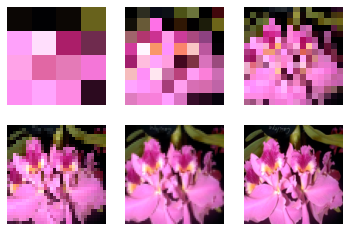

In [6]:
filenames = glob(dataroot+"*")
transform=transforms.Compose([transforms.RandomCrop(image_size),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomHorizontalFlip(),
                              transforms.ColorJitter(brightness=0.1, contrast=0.05, saturation=0, hue=0),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
dataset = dataset_flowers(filenames, imsize=image_size, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, drop_last=True, num_workers=workers)

images = dataset.__getitem__(0)
plot_images(images, show = True, save = False)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

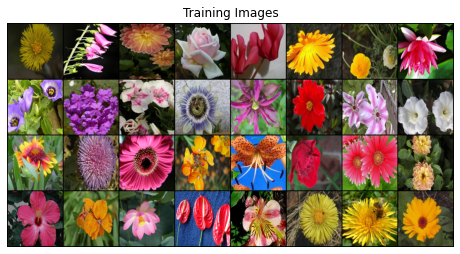

In [7]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[-1].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Funciones modelos general

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal_(m.weight.data, gain=math.sqrt(2))
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight.data, gain=math.sqrt(2))
        
def save_model(netG, netD, epoch, model_dir):
    torch.save(
        netG.state_dict(),
        '%s/netG_epoch_%d.pth' % (model_dir, epoch))
    torch.save(
        netD.state_dict(),
        '%s/netD_epoch_last.pth' % (model_dir))
    print('Save G/D models')
    
    
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes, last = False):
    if last:
        block = nn.Sequential(
            conv3x3(in_planes, 3),
            nn.Tanh())
    else:
        block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            conv3x3(in_planes, out_planes),
            conv3x3(out_planes, out_planes),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True))
    return block

In [9]:
def save_model(netG, netD, epoch, model_dir):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir) 
    torch.save(
        netG.state_dict(),
        '%s/netG_epoch_%d.pth' % (model_dir, epoch))
    torch.save(
        netD.state_dict(),
        '%s/netD_epoch_last.pth' % (model_dir))
    #print('Save G/D models')

# Generator

In [10]:
ngf = 1024

In [11]:
class Generator(nn.Module):
    def __init__(self, ):
        super(Generator, self).__init__()

        
        self.fc = nn.Sequential(nn.Linear(nz, ngf * 2 * 2, bias=False))
        
        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        self.upsample4 = upBlock(ngf // 8, ngf // 16)
        self.upsample5 = upBlock(ngf // 16, ngf // 32)
        self.upsample6 = upBlock(ngf // 32, ngf // 64)

        self.out1 = upBlock(ngf // 2, 3, True)
        self.out2 = upBlock(ngf // 4, 3, True)
        self.out3 = upBlock(ngf // 8, 3, True)
        self.out4 = upBlock(ngf // 16, 3, True)
        self.out5 = upBlock(ngf // 32, 3, True)
        self.out6 = upBlock(ngf // 64, 3, True)

    def forward(self, z):
        latent = self.fc(z)
        latent = latent.view(-1, ngf, 2, 2)
        x1 = self.upsample1(latent)
        x2 = self.upsample2(x1)
        x3 = self.upsample3(x2)
        x4 = self.upsample4(x3)
        x5 = self.upsample5(x4)
        x6 = self.upsample6(x5)
        
        x1 = self.out1(x1)
        x2 = self.out2(x2)
        x3 = self.out3(x3)
        x4 = self.out4(x4)
        x5 = self.out5(x5)
        x6 = self.out6(x6)
        return [x1, x2, x3, x4, x5, x6]

In [12]:
netG = Generator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
summary(netG, input_size=(batch_size, nz))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 4, 4]             --
├─Sequential: 1-1                        [32, 4096]                --
│    └─Linear: 2-1                       [32, 4096]                524,288
├─Sequential: 1-2                        [32, 512, 4, 4]           --
│    └─Upsample: 2-2                     [32, 1024, 4, 4]          --
│    └─Conv2d: 2-3                       [32, 512, 4, 4]           4,718,592
│    └─Conv2d: 2-4                       [32, 512, 4, 4]           2,359,296
│    └─BatchNorm2d: 2-5                  [32, 512, 4, 4]           1,024
│    └─ReLU: 2-6                         [32, 512, 4, 4]           --
├─Sequential: 1-3                        [32, 256, 8, 8]           --
│    └─Upsample: 2-7                     [32, 512, 8, 8]           --
│    └─Conv2d: 2-8                       [32, 256, 8, 8]           1,179,648
│    └─Conv2d: 2-9                       [32, 256, 8, 8]

# Discriminator

In [13]:
ndf = 64

In [14]:
def downBlock(in_planes, out_planes):
    block = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25)) #,nn.ReLU(True))
    return block
def process_block(out_planes):
    block = nn.Sequential(
            nn.Conv2d(3, out_planes, 1, 1, "same", bias=False),
            nn.LeakyReLU(0.2, inplace=True)) 
    return block

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        
        
        #self.downBlock1 = nn.Sequential(
        #            nn.Conv2d(3, ndf, 3, 2, 1, bias=False),
        #            nn.LeakyReLU(0.2, inplace=True))
        self.downBlock1 = downBlock(ndf, ndf)
        self.downBlock2 = downBlock(ndf+ndf, 2*ndf)
        self.downBlock3 = downBlock(ndf+2*ndf, 4*ndf)
        self.downBlock4 = downBlock(ndf+4*ndf, 8*ndf)
        self.downBlock5 = downBlock(ndf+8*ndf, 16*ndf)
        
        self.process1 = process_block(ndf)
        self.process2 = process_block(ndf)
        self.process3 = process_block(ndf)
        self.process4 = process_block(ndf)
        self.process5 = process_block(ndf)
        self.process6 = process_block(ndf)
        
        self.final_layer = nn.Sequential(nn.Conv2d(ndf+16*ndf, 1, 4, 4, 1, bias=False),
                                nn.Sigmoid())
        
        
    def forward(self, x1, x2, x3, x4, x5, x6):
        
        x1 = self.process1(x1)
        x2 = self.process2(x2)
        x3 = self.process3(x3)
        x4 = self.process4(x4)
        x5 = self.process5(x5)
        x6 = self.process6(x6)

        x = self.downBlock1(x6)
        x = torch.cat([x,x5],1)
        x = self.downBlock2(x)
        x = torch.cat([x,x4],1)
        x = self.downBlock3(x)
        x = torch.cat([x,x3],1)
        x = self.downBlock4(x)
        x = torch.cat([x,x2],1)
        x = self.downBlock5(x)
        x = torch.cat([x,x1],1)
        x = self.final_layer(x).view(-1, 1).squeeze(1)
        
        return x

In [15]:
netD = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
summary(netD, input_size=((batch_size, 3, 4, 4), (batch_size, 3, 8, 8), (batch_size, 3, 16, 16),
                          (batch_size, 3, 32, 32), (batch_size, 3, 64, 64), (batch_size, 3, 128, 128)))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32]                      --
├─Sequential: 1-1                        [32, 64, 4, 4]            --
│    └─Conv2d: 2-1                       [32, 64, 4, 4]            192
│    └─LeakyReLU: 2-2                    [32, 64, 4, 4]            --
├─Sequential: 1-2                        [32, 64, 8, 8]            --
│    └─Conv2d: 2-3                       [32, 64, 8, 8]            192
│    └─LeakyReLU: 2-4                    [32, 64, 8, 8]            --
├─Sequential: 1-3                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-5                       [32, 64, 16, 16]          192
│    └─LeakyReLU: 2-6                    [32, 64, 16, 16]          --
├─Sequential: 1-4                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-7                       [32, 64, 32, 32]          192
│    └─LeakyReLU: 2-8                    [32, 64, 32, 32]          --
├─Sequentia

# Train

In [16]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))


In [17]:
def prepare_data(images):
    images_var = []
    for im in images:
        images_var.append(Variable(im).to(device))
    return images_var
def train_d(real_images, fake_images):
    netD.zero_grad()
    real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
    fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
    real_labels = real_labels + torch.distributions.uniform.Uniform(-0.2,0).sample((batch_size,)).to(device)

    x1, x2, x3, x4, x5, x6 = real_images
    f1, f2, f3, f4, f5, f6 = fake_images
    f1, f2, f3, f4, f5, f6 = f1.detach(), f2.detach(), f3.detach(), f4.detach(), f5.detach(), f6.detach()
    out_real = netD(x1, x2, x3, x4, x5, x6)
    out_fake = netD(f1, f2, f3, f4, f5, f6)
    
    errR = criterion(out_real, real_labels)
    errF = criterion(out_fake, fake_labels)
    errR.backward()
    errF.backward()
    err =  errR + errF
    optimizerD.step()
    return err
def train_g(fake_images):
    netG.zero_grad()
    real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
    f1, f2, f3, f4, f5, f6 = fake_images
    out_fake = netD(f1, f2, f3, f4, f5, f6)
    errG = criterion(out_fake, real_labels)
    errG.backward()
    optimizerG.step()
    return errG

In [18]:
G_losses = []
D_losses = []
for epoch in tqdm(range(num_epochs)):
    errD = 0
    errG = 0
    for i, data in enumerate(dataloader, 0):
        real_images = prepare_data(data)
        #Train D
        noise = torch.randn(batch_size, nz, device=device)
        fake_images = netG(noise)
        errD += train_d(real_images, fake_images)
        
        #Train G
        noise = torch.randn(batch_size, nz, device=device)
        fake_images = netG(noise)
        errG += train_g(fake_images)
    D_losses.append(errD.item()/i)
    G_losses.append(errG.item()/i)
    save_losses_plot(G_losses, D_losses)
    f_image = []
    for f in fake_images:
        f_image.append(f[0].cpu().detach())
    plot_images(f_image, show = False, save = True, epoca = epoch)
    print("Epoch:",epoch, "\tLossD:", D_losses[-1], "\tLossG:", G_losses[-1])
    save_model(netG, netD, epoch, "./modelos")

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 0 	LossD: 1.1049708569143701 	LossG: 3.179523377906619
Epoch: 1 	LossD: 0.9180592814768394 	LossG: 3.330413818359375
Epoch: 2 	LossD: 0.8219229029858206 	LossG: 3.4703051950049213
Epoch: 3 	LossD: 0.9005077692467397 	LossG: 3.016728438730315
Epoch: 4 	LossD: 0.9408651036540354 	LossG: 3.108939824141855
Epoch: 5 	LossD: 0.9396886750469058 	LossG: 3.3076825479822833
Epoch: 6 	LossD: 0.8820117139440822 	LossG: 3.407041534664124
Epoch: 7 	LossD: 0.8694861704908957 	LossG: 3.6089463121309056
Epoch: 8 	LossD: 0.8982334287147823 	LossG: 3.681590403158834
Epoch: 9 	LossD: 0.8674265343373216 	LossG: 3.7004257562592273
Epoch: 10 	LossD: 0.8092879047543984 	LossG: 4.1876350462906
Epoch: 11 	LossD: 1.1619650773176058 	LossG: 4.06428299550935
Epoch: 12 	LossD: 0.662749282957062 	LossG: 4.801811638779528
Epoch: 13 	LossD: 0.6981225802203802 	LossG: 4.508284441129429
Epoch: 14 	LossD: 0.959772064929872 	LossG: 4.342203936238927
Epoch: 15 	LossD: 0.8559664027897391 	LossG: 4.626972829263042
Epo

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

# Metricas